# Dilution of Precision (DOP) Calculations

Contributed by Michael P. Jones

## Configuration

This example uses 1 day with a 10 second time step. The minimum elevation angle from the user for a satellite to be considered in view is set to 5 degrees. 

In [1]:
from datetime import datetime, timedelta, timezone
import pandas as pd
import numpy as np

# Initial conditions
start = datetime(2023, 7, 1, 0, tzinfo=timezone.utc)
stop = start + timedelta(days=1)
total_t = stop - start
time_step = timedelta(seconds=10)

# Make vector of times at which to take measurements
t_vec = pd.Series(
    [
        start + timedelta(seconds=i)
        for i in np.arange(
            0,
            total_t.total_seconds() + time_step.total_seconds(),
            time_step.total_seconds(),
        )
    ]
)

# Seed orbit initial conditions
raan = 0  # right ascension of ascending node for initial plane
alt = 20200e3  # altitude of orbit in meters
phasing = 1  # phase angle between planes
inc = 55  # inclination of orbit

# Define the min elevation angle for the DOP measurements
min_el = 5

Define a seed satellite and then create a Walker Constellation

A GPS-like constellation is a Walker Delta with a 24/6/1 configuration and an inclination of 55deg

In [2]:
from tatc.schemas import (
    Satellite,
    CircularOrbit,
    WalkerConstellation,
    Point,
)

# Create a seed satellite
s1 = Satellite(
    name="satellite1",
    orbit=CircularOrbit(
        altitude=alt,
        inclination=inc,
        type="circular",
        right_ascension_ascending_node=raan,
        epoch=start,
    ),
)

# Create a Walker Constellation
wc = WalkerConstellation(
    name="walker1",
    orbit=s1.orbit,
    number_planes=6,
    number_satellites=24,
    configuration="delta",
    relative_spacing=phasing,
).generate_members()

Create a grid of ground points at which to make measurements

In [3]:
from tatc.generation import generate_equally_spaced_points

# define points on ground to measure DOP
pts_df = generate_equally_spaced_points(5000e3)

points = pts_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

## Evaluate the DOP

First get the position-dilution of precision (PDOP). The function is slow depending on the size of the time vector and the number of ground points to evaluate, so running in parallel is advised. 

In [4]:
from tatc.analysis import compute_dop
from joblib import Parallel, delayed

p_dops = Parallel(n_jobs=-1, verbose=1)(
    delayed(compute_dop)(t_vec, i, wc, min_el, "pdop") for i in points
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  32 | elapsed:    6.0s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    8.2s finished


The get_dop function can also calculate the GDOP, HDOP, VDOP, and TDOP. 

- Geomtric DOP (GDOP) is related to errors in both position and time. GDOP is the root sum of squares of the PDOP and TDOP
- Position DOP (PDOP) is related to position error in the users horizontal and vertical planes
- Horizontal DOP (HDOP) is related to position error in the horizontal plane of the user (i.e. latitude and longitude)
- Vertical DOP (VDOP) is related to position error in the vertical plane of the user (i.e. altitude)
- Time DOP (TDOP) is related to time error. It is the root of the squares of GDOP minues PDOP.

In [5]:
# Examples of the different DOP methods:
g_dop = compute_dop(t_vec, points[0], wc, min_el, "gdop")

h_dop = compute_dop(t_vec, points[0], wc, min_el, "hdop")

v_dop = compute_dop(t_vec, points[0], wc, min_el, "vdop")

t_dop = compute_dop(t_vec, points[0], wc, min_el, "tdop")

### Time Plots
The DOP values can be plotted vs time for the duration of the simluation

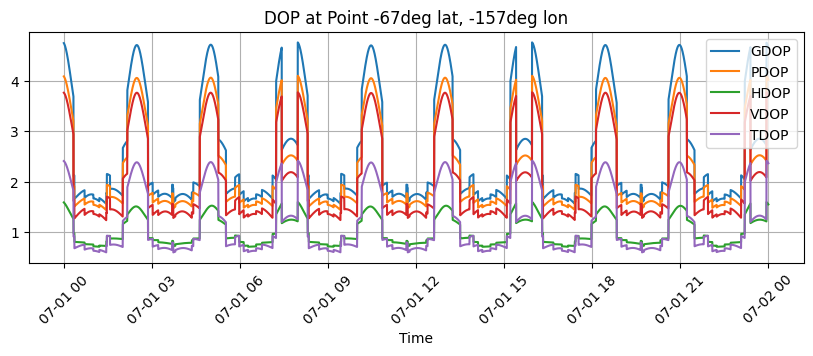

In [6]:
import matplotlib.pyplot as plt

x = t_vec
plt.figure(figsize=(10, 3))
plt.plot(x, g_dop["dop"], label="GDOP")
plt.plot(x, p_dops[0]["dop"], label="PDOP")
plt.plot(x, h_dop["dop"], label="HDOP")
plt.plot(x, v_dop["dop"], label="VDOP")
plt.plot(x, t_dop["dop"], label="TDOP")
plt.legend(loc="upper right")
plt.title("DOP at Point -67deg lat, -157deg lon")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Map Plots
Instead of DOP vs Time, can take the mean DOP and plot on a map showing the ground point locations.

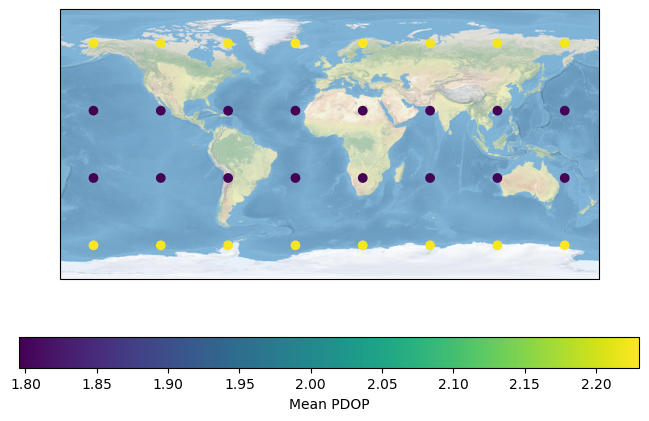

In [7]:
# Make a copy of the points geodataframe
pts_df_dop = pts_df.copy()

# Add mean PDOP values for each point to the geodataframe
pts_df_dop["PDOP"] = [np.mean(p_dops[i]["dop"]) for i in range(len(p_dops))]

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Make a plot with circles
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})

pts_df_dop.plot(
    ax=ax,
    column="PDOP",
    cmap="viridis",
    legend=True,
    legend_kwds={"label": "Mean PDOP", "orientation": "horizontal"},
    transform=ccrs.PlateCarree()
)
ax.stock_img()
ax.set_global()
plt.show()

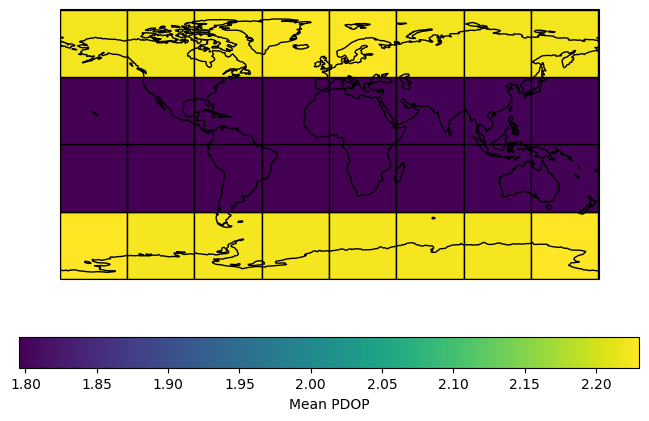

In [8]:
from tatc.generation import generate_equally_spaced_cells

# Make a plot with shaded cells
cells_df = generate_equally_spaced_cells(5000e3)
cells_df["PDOP"] = [np.mean(p_dops[i]["dop"]) for i in range(len(p_dops))]

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})
cells_df.plot(
    ax=ax,
    column="PDOP",
    cmap="viridis",
    edgecolor="k",
    legend=True,
    legend_kwds={"label": "Mean PDOP", "orientation": "horizontal"},
    transform=ccrs.PlateCarree()
)
ax.coastlines()
ax.set_global()
plt.show()

## Verification

Using equivalent initial conditions and simulation parameters, AGI's STK generates the same results as this program to 2 decimal places.

The shape of the DOP vs time curve also matches.

Comparisons were also carried out at different latitudes and with different constellation parameters.

In [9]:
import geopandas as gpd
import numpy as np

# Make a point located at 0deg lat, 0deg lon
# Calculate PDOP value at 0deg lat 0 deg lon from 05 July 2023 at 1600 with 60 deg time step and Walker Delta 24/6/1 constellation.
point_0_0 = Point(id=0, latitude=0, longitude=0)
point_0_0_df = gpd.GeoDataFrame(
    [point_0_0.id],
    geometry=gpd.points_from_xy([point_0_0.longitude], [point_0_0.latitude]),
    crs="EPSG:4326",
    columns=["point_id"],
)
pdop_0_0 = compute_dop(t_vec, point_0_0, wc, min_el, "pdop")
print(point_0_0_df.geometry)
print("Mean PDOP: ", np.mean(pdop_0_0["dop"]))
print("Max PDOP: ", np.max(pdop_0_0["dop"]))
print("Min PDOP: ", np.min(pdop_0_0["dop"]))

0    POINT (0 0)
Name: geometry, dtype: geometry
Mean PDOP:  1.7481994840847743
Max PDOP:  1.9493918789245415
Min PDOP:  1.4223627484939771


Results from get_dop() function: 
- Mean PDOP: 1.74483
- Max PDOP: 1.95012
- Min PDOP: 1.4214

From equivalent STK simulation:
- Mean PDOP: 1.74708
- Max PDOP: 1.94902
- Min PDOP: 1.42266

### TATC Plot of PDOP over time at 0 deg Lat / 0 deg Lon

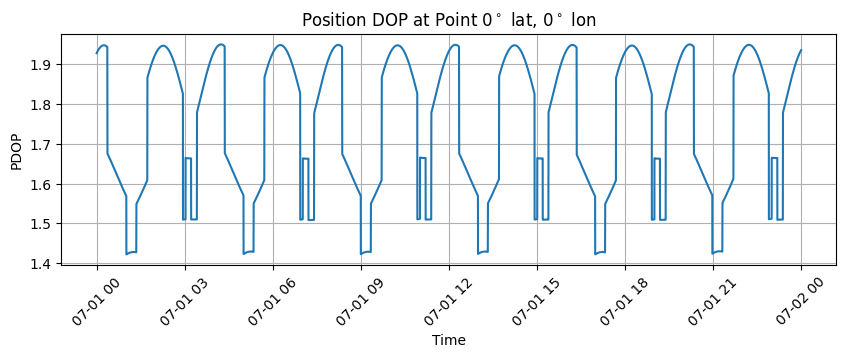

In [10]:
import matplotlib.pyplot as plt

x = t_vec
y = pdop_0_0["dop"]
plt.figure(figsize=(10, 3))
plt.plot(x, y)
plt.title("Position DOP at Point $0^\circ$ lat, $0^\circ$ lon")
plt.xlabel("Time")
plt.ylabel("PDOP")
plt.xticks(rotation=45)
plt.grid()
plt.show()

### STK Plot of PDOP over time for 0 deg lat / 0 deg lon

<img src="../_static/ComputeDOP/coverage.png" width=600>